### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [20]:
from sklearn.datasets import fetch_openml

In [21]:
wages = fetch_openml(data_id=534, as_frame=True)

In [22]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import plotly.express as px
import pandas as pd
import warnings

In [27]:
categorical_features = ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']
out = pd.get_dummies(
    data=wages.frame,
    columns=categorical_features)
wages_enc = out.replace({False: 0, True: 1})
wages_enc

/var/folders/y9/r7f8nxh14dzdhxcqwh2vmrw80000gq/T/ipykernel_21840/1656905380.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wages_enc = out.replace({False: 0, True: 1})


,EDUCATION,EXPERIENCE,WAGE,AGE,SOUTH_no,SOUTH_yes,SEX_female,SEX_male,UNION_member,UNION_not_member,...,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Married,MARR_Unmarried
0,8,21,5.10,35,1,0,1,0,0,1,...,0,1,0,0,0,0,1,0,1,0
1,9,42,4.95,57,1,0,1,0,0,1,...,0,1,0,0,0,0,1,0,1,0
2,12,1,6.67,19,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,1
3,12,4,4.00,22,1,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,1
4,12,17,7.50,35,1,0,0,1,0,1,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,18,5,11.36,29,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,1
530,12,33,6.10,51,1,0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,0
531,17,25,23.25,48,1,0,1,0,1,0,...,0,0,1,0,0,0,0,1,1,0
532,12,13,19.88,31,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,1,0


In [28]:
from sklearn.model_selection import train_test_split

X = wages_enc.drop(['WAGE'], axis=1)
y = wages_enc['WAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
# Create the TransformedTargetRegressor with logarithm
regressor = TransformedTargetRegressor(regressor=None,
                                       func=np.log,
                                       inverse_func=np.exp)

# Define the parameter grid for grid search
param_grid = {
    'regressor': [Ridge(), Lasso()],
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=regressor,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_train, y_train)

/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e+00, tolerance: 8.158e-03
  model = cd_fast.enet_coordinate_descent(
/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e+00, tolerance: 8.210e-03
  model = cd_fast.enet_coordinate_descent(
/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might wa

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>),
             param_grid={'regressor': [Ridge(), Lasso()],
                         'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

Best Estimator: TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Ridge(alpha=10))
Best Parameters: {'regressor': Ridge(), 'regressor__alpha': 10}


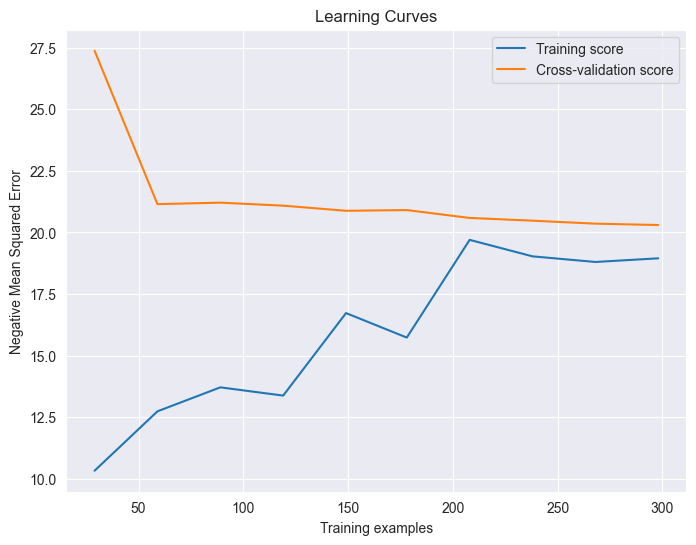

In [37]:
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve

# Get the best estimator and best parameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Estimator:", best_estimator)
print("Best Parameters:", best_params)

# Plot the learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_estimator, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Negative Mean Squared Error')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()